In [1]:
!pip install keras

    100% |████████████████████████████████| 337kB 2.7MB/s ta 0:00:01
    100% |████████████████████████████████| 256kB 3.0MB/s ta 0:00:01
    100% |████████████████████████████████| 46.7MB 25kB/s  eta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /home/aladetan/.cache/pip/wheels/03/05/65/bdc14f2c6e09e82ae3e0f13d021e1b6b2481437ea2f207df3f
Successfully built pyyaml
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [158]:
!pip install scikit-learn

    100% |████████████████████████████████| 12.2MB 87kB/s  eta 0:00:01
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [121]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
import spotipy
from spotipy import util
from config import config

In [77]:
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(client_id=config['spotify_id'], client_secret=config['spotify_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Quick tools

### check # of (all) labelled songs and features

In [128]:
l = pd.read_json('labelled', orient='rows')
f  = pd.read_json('features')
print(l.shape[1])
print(f.shape[0])
print l.shape[1] == f.shape[0]

1270
1270
True


## Data Collection

Features are already downloaded to save time/bandwith, but will continue to recollect data in notebook until data is too big/labelling is done

In [129]:
labelled = json.load(open('labelled'))

In [390]:
def mood_encode(moods):
    values = {'chill':0, 'hype':2, 'happy':0, 'sad':1}
#     chill happy 0
#     chill sad 1
#     hype happy 2
#     hype sad 3
    output = 0
    for mood in moods:
        output += values[mood]
        
    return output

In [391]:
sample = []
for row in labelled:
    label = mood_encode(labelled[row]['mood'])
    sample.append([row,labelled[row]['name'],label])
songs = pd.DataFrame(sample, columns=['id','title','label']).set_index('id')
songs.head()

,title,label
id,,
3KNlsVwlMjjKn1g2tTmiIe,She Said,2
72X7mJmnx6pHyRWvtelVkL,Safe,2
6BbINUfGabVyiNFJpQXn3x,Wicked,2
3s2eG9xSDGyd705tT0hD43,Magic City,2
2ImWMn8Pqxa8gHfk1ZJvAh,Use My Heart,1


In [392]:
features = pd.read_json('features').drop(columns=['analysis_url','track_href','uri','type']).set_index('id')
features.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
id,,,,,,,,,,,,,
4l94386YhnCzduk44xzFRx,0.00594,0.547,170960,0.848,0.000000,2,0.0743,-5.622,1,0.0680,128.987,4,0.393
07RULM1xjoEaal27GAsioi,0.21500,0.602,230027,0.678,0.000000,7,0.1150,-6.946,1,0.0300,95.496,4,0.922
1FvU97lrWOG2NRxErh6OZz,0.06330,0.897,334467,0.661,0.000000,8,0.1160,-6.200,0,0.2700,127.081,4,0.193
4XYOnP0tFe8ifE3hHitQBF,0.66700,0.528,189240,0.288,0.000000,0,0.1130,-8.608,0,0.0262,95.389,4,0.294
5NGcTyu5c4o5OQN2qDHMuq,0.32100,0.668,183053,0.759,0.000001,9,0.1470,-6.394,1,0.1380,198.052,4,0.925


In [393]:
data = songs.join(features)
data.head()

,title,label,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
id,,,,,,,,,,,,,,,
3KNlsVwlMjjKn1g2tTmiIe,She Said,2,0.00030,0.418,224640,0.945,0.00000,7,0.1060,-3.757,1,0.0683,165.041,4,0.693
72X7mJmnx6pHyRWvtelVkL,Safe,2,0.13800,0.691,185822,0.798,0.00000,9,0.3040,-4.493,1,0.0360,102.031,4,0.905
6BbINUfGabVyiNFJpQXn3x,Wicked,2,0.00191,0.718,173347,0.679,0.01040,11,0.3850,-5.899,0,0.0706,157.970,4,0.205
3s2eG9xSDGyd705tT0hD43,Magic City,2,0.08410,0.757,175238,0.867,0.09920,0,0.1250,-2.529,0,0.0362,125.962,4,0.499
2ImWMn8Pqxa8gHfk1ZJvAh,Use My Heart,1,0.20900,0.361,230253,0.658,0.00456,9,0.0887,-9.365,1,0.0400,82.979,4,0.169


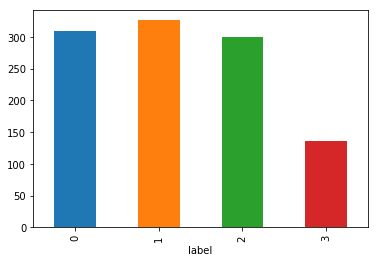

In [397]:
data.groupby(['label']).title.count().plot(kind='bar')

In [396]:
#trying to remove some 3 to compensate
three_rows = data.loc[data['label'] == 2]
drop_indices = np.random.choice(three_rows.index, 200, replace=False)
data = data.drop(drop_indices)

Need to reshape df to numpy array for keras

In [398]:
array = np.float32(data.drop(columns=['title']).values)
x = array[:,1:]
y = array[:,0]
y_cat = np_utils.to_categorical(y)
dimension = x.shape[1]
print(dimension)
print(y)
print(y_cat)

13
[2. 2. 2. ... 1. 1. 2.]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


## First NN Attempt

In [362]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils

In [363]:
np.random.seed(7)

### Model

In [399]:
model = Sequential()
model.add(Dense(50, input_dim=dimension, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(dimension, activation='relu'))
model.add(Dense(4, activation='softmax'))

### Compiling

In [400]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fit

In [401]:
model.fit(x, y_cat, epochs=10, batch_size=30)

Epoch 1/10
1070/1070 [==============================] - 1s 1ms/step - loss: 11.4634 - acc: 0.2888
Epoch 2/10
1070/1070 [==============================] - 0s 84us/step - loss: 11.4634 - acc: 0.2888
Epoch 3/10
1070/1070 [==============================] - 0s 86us/step - loss: 11.4634 - acc: 0.2888
Epoch 4/10
1070/1070 [==============================] - 0s 81us/step - loss: 11.4634 - acc: 0.2888
Epoch 5/10
1070/1070 [==============================] - 0s 86us/step - loss: 11.4634 - acc: 0.2888
Epoch 6/10
1070/1070 [==============================] - 0s 80us/step - loss: 11.4634 - acc: 0.2888
Epoch 7/10
1070/1070 [==============================] - 0s 89us/step - loss: 11.4634 - acc: 0.2888
Epoch 8/10
1070/1070 [==============================] - 0s 74us/step - loss: 11.4634 - acc: 0.2888
Epoch 9/10
1070/1070 [==============================] - 0s 88us/step - loss: 11.4634 - acc: 0.2888
Epoch 10/10
1070/1070 [==============================] - 0s 86us/step - loss: 11.4634 - acc: 0.2888


### Evaluation

In [70]:
### need to split up testing and training data

In [402]:
# evaluate the model
scores = model.evaluate(x, y_cat)
# scores = model.evaluate(x, y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1070/1070 [==============================] - 0s 457us/step

acc: 28.88%


### Predicting

Input a new song a get a prediction

In [325]:
spotify_song_id = '2KRQR1VK6OoJxpwVzwDv72' #funky duck by vulfpeck

In [403]:
spotify_song_id = '2gTYVoQCUh0QNUaFix01ld' #chun-li by nicki minaj

In [369]:
spotify_song_id = '3cZN7WvYk8efaoXqxT70Qf' #typhoon by young the giant

In [404]:
song_features = sp.audio_features([spotify_song_id])
song_input = pd.DataFrame(song_features).drop(columns=['analysis_url','track_href','uri','type']).set_index('id')
song_np = song_input.values
print(song_np)

[[ 3.07000e-01  6.43000e-01  1.91606e+05  7.66000e-01  1.38000e-05
   6.00000e+00  1.07000e-01 -4.78800e+00  0.00000e+00  3.84000e-01
   9.70920e+01  4.00000e+00  4.63000e-01]]


In [405]:
predictions = model.predict(song_np)
# rounded = [round(x[0]) for x in predictions]
print(predictions)

[[1. 0. 0. 0.]]
